## Import library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.optim as optim
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
import time
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


# Arrhythmia Dataset

In [2]:
import os
print(os.listdir("../input"))

['ptbdb_abnormal.csv', 'ptbdb_normal.csv', 'mitbih_test.csv', 'mitbih_train.csv']


## Load data & explore

In [3]:
train_data = pd.read_csv("/kaggle/input/mitbih_train.csv")
test_data = pd.read_csv("/kaggle/input/mitbih_test.csv")

In [4]:
print(f"Number of samples in train data: {train_data.shape[0]}")
print(f"Number of samples in test data: {test_data.shape[0]}")

Number of samples in train data: 87553
Number of samples in test data: 21891


In [5]:
train_data.head()

,9.779411554336547852e-01,9.264705777168273926e-01,6.813725233078002930e-01,2.450980395078659058e-01,1.544117629528045654e-01,1.911764740943908691e-01,1.519607901573181152e-01,8.578431606292724609e-02,5.882352963089942932e-02,4.901960864663124084e-02,...,0.000000000000000000e+00.79,0.000000000000000000e+00.80,0.000000000000000000e+00.81,0.000000000000000000e+00.82,0.000000000000000000e+00.83,0.000000000000000000e+00.84,0.000000000000000000e+00.85,0.000000000000000000e+00.86,0.000000000000000000e+00.87,0.000000000000000000e+00.88
0,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.927461,1.000000,0.626943,0.193437,0.094991,0.072539,0.043178,0.053541,0.093264,0.189983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Missing values

In [6]:
print(f"Missing values in train data: {train_data.isna().sum().sum()}")
print(f"Missing values in test data: {test_data.isna().sum().sum()}")

Missing values in train data: 0
Missing values in test data: 0


In [7]:
print(f"Duplicated values in train data: {train_data.duplicated().sum()}")
print(f"Duplicated values in test data: {test_data.duplicated().sum()}")

Duplicated values in train data: 0
Duplicated values in test data: 0


## Plot ECG

In [8]:
# Input labels
labels = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}

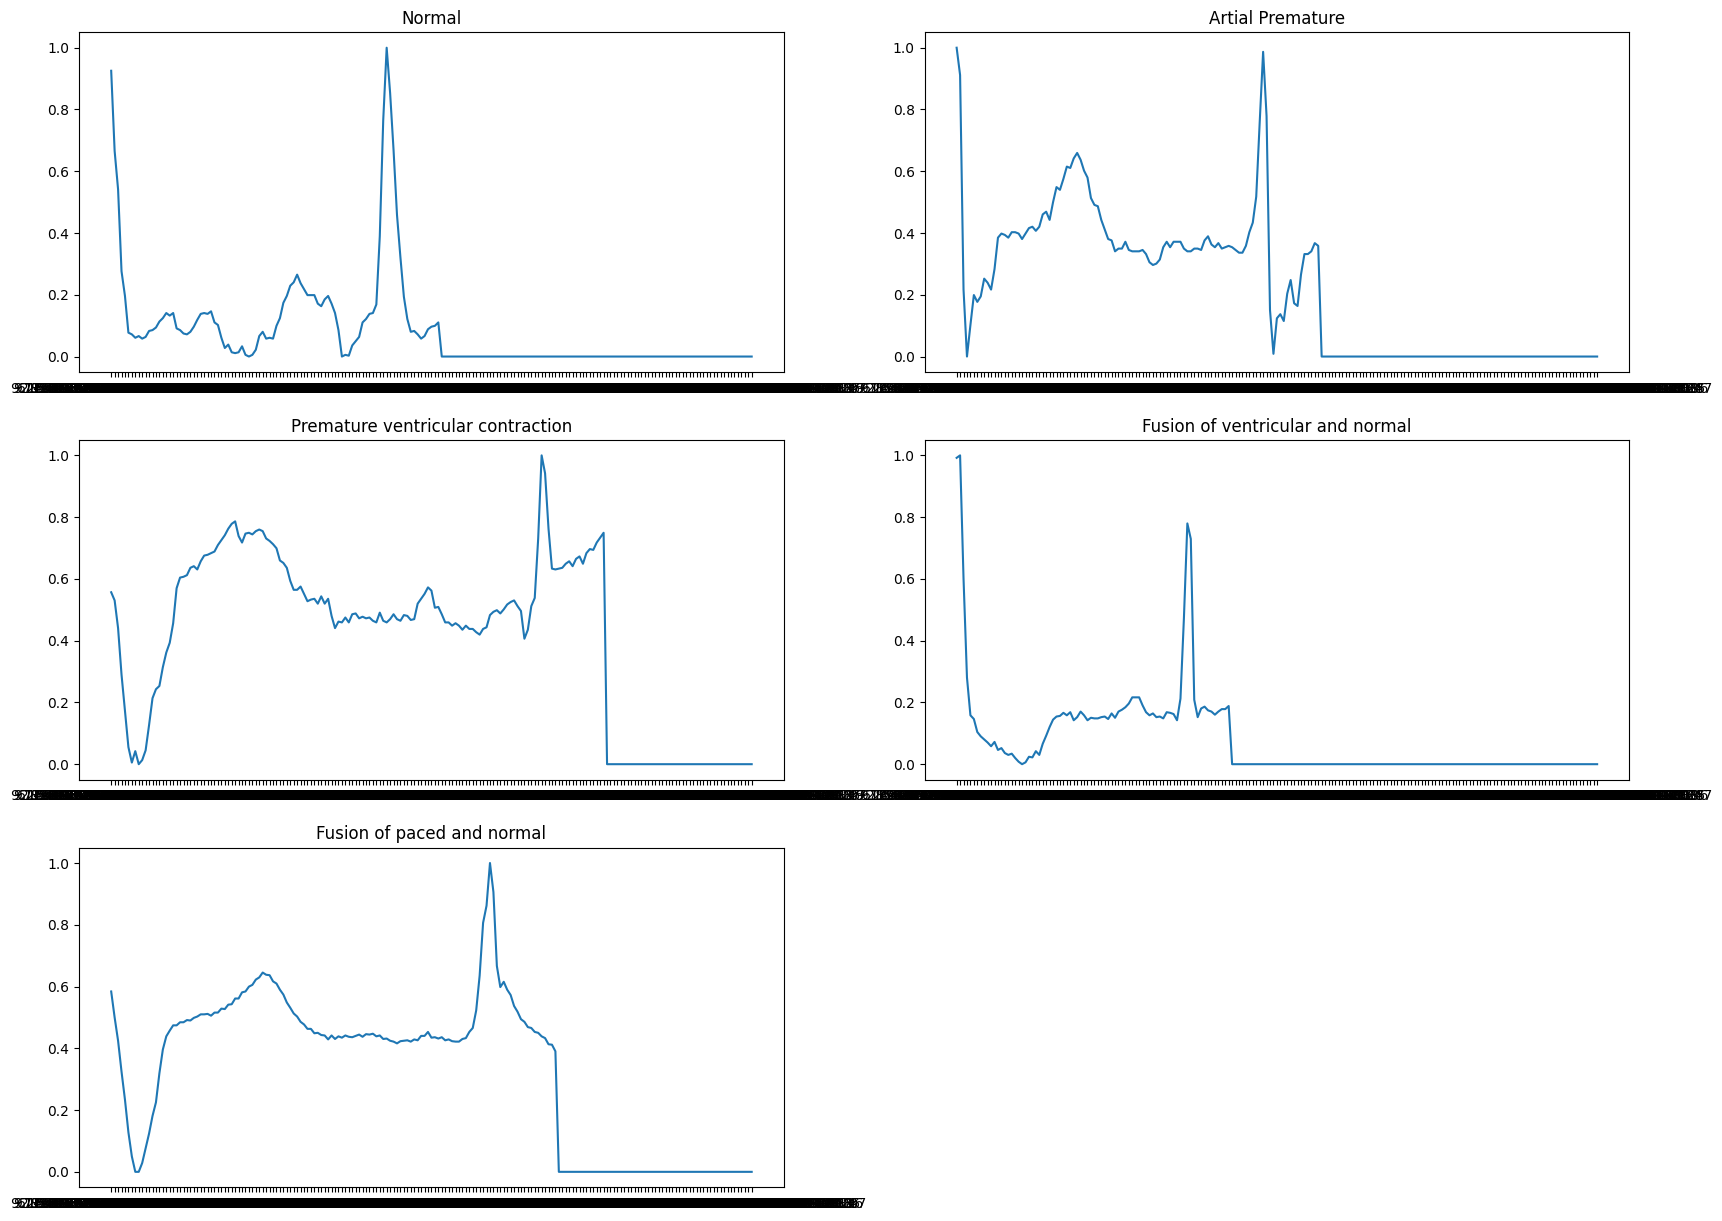

In [9]:
train_classes = train_data.iloc[:,-1].unique()

plt.figure(figsize=(20,15))

for idx, cls in enumerate(train_classes):
    plt.subplot(3,2,idx+1)
    plt.plot(train_data[train_data.iloc[:,-1]==cls].iloc[2,:-1])
    plt.title(labels[idx])

plt.show()

We can see that their is a time relationship in the x-axis, so it is my intention to use time series based model to process this data. We gonna talk about that later

# Value count

Text(0, 0.5, 'Number of samples')

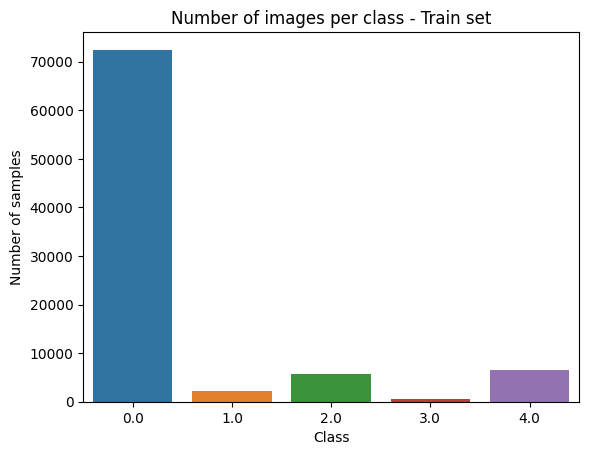

In [10]:
value_counts = train_data.iloc[:,-1].value_counts()
fig_train = sns.barplot(x=value_counts.index, y=value_counts.values)
plt.title('Number of images per class - Train set')
plt.xlabel('Class')
plt.ylabel('Number of samples')

Text(0, 0.5, 'Number of samples')

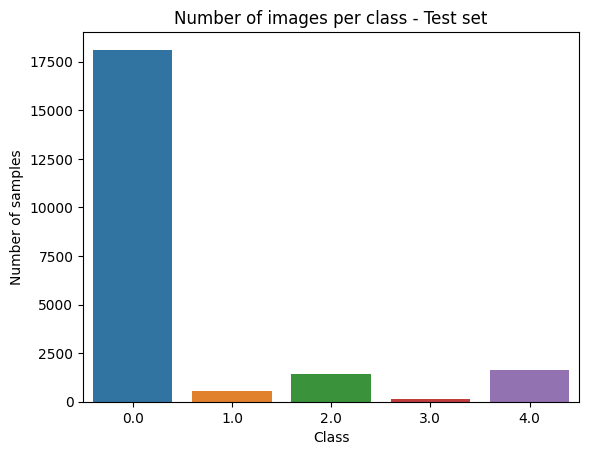

In [11]:
value_counts = test_data.iloc[:,-1].value_counts()
fig_test = sns.barplot(x=value_counts.index, y=value_counts.values)
plt.title('Number of images per class - Test set')
plt.xlabel('Class')
plt.ylabel('Number of samples')

We can see that the dataset is heavily imbalanced. Thereby it is more reasonable to apply a sampling approach to handle this dataset properly

## Weight sampling

In [12]:
len(train_data)

87553

In [13]:
class_counts = train_data.iloc[:,-1].value_counts().to_dict()
class_weights = {cls:len(train_data)/count for cls, count in class_counts.items()}
sample_weights = [class_weights[target] for target in train_data.iloc[:,-1]]
sample_weights[:5]

[1.208127501034911,
 1.208127501034911,
 1.208127501034911,
 1.208127501034911,
 1.208127501034911]

In [14]:
print(class_weights)

{0.0: 1.208127501034911, 4.0: 13.614212408645622, 2.0: 15.126641326883206, 1.0: 39.38506522717049, 3.0: 136.58814352574103}


In [15]:
sampler = WeightedRandomSampler(weights = sample_weights, num_samples = len(sample_weights), replacement = True)

## Define train and test dataset

In [16]:
ecg_train = train_data.iloc[:,:-1].values
label_train = train_data.iloc[:,-1].values
ecg_test = test_data.iloc[:,:-1].values
label_test = test_data.iloc[:,-1].values

print(ecg_train.shape, label_train.shape, ecg_test.shape, label_test.shape)

(87553, 187) (87553,) (21891, 187) (21891,)


In [17]:
# Scailing the data

scaler = MinMaxScaler()
ecg_train_scaled = scaler.fit_transform(ecg_train)
ecg_test_scaled = scaler.transform(ecg_test)

# Define the number of samples for the validation set based on the test data size
n_test_samples = ecg_test.shape[0]

# Split the training data into new training and validation sets
ecg_val, ecg_test, label_val, label_test = train_test_split(ecg_test_scaled, label_test, test_size=0.5, random_state=6, stratify=label_test)

# Reshape the data for LSTM (samples, timesteps, features)
ecg_train_scaled = np.reshape(ecg_train_scaled, (ecg_train_scaled.shape[0], ecg_train_scaled.shape[1]))
ecg_val = np.reshape(ecg_val, (ecg_val.shape[0], ecg_val.shape[1]))
ecg_test = np.reshape(ecg_test, (ecg_test.shape[0], ecg_test.shape[1]))


print(f"New Training set size: {ecg_train_scaled.shape[0]}")
print(f"Validation set size: {ecg_val.shape[0]}")
print(f"Test set size: {ecg_test.shape[0]}")

New Training set size: 87553
Validation set size: 10945
Test set size: 10946


Text(0.5, 1.0, 'Train - Test split ratio')

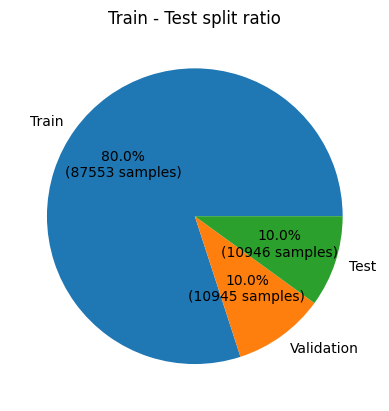

In [18]:
def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d} samples)"
plt.pie((ecg_train_scaled.shape[0], ecg_val.shape[0], ecg_test.shape[0]), labels = ["Train", "Validation", "Test"], autopct=lambda pct: func(pct, (ecg_train_scaled.shape[0], ecg_val.shape[0], ecg_test.shape[0])))
plt.title('Train - Test split ratio')

In [19]:
print("Train shape: ", ecg_train_scaled.shape)
print("Label train shape: ", label_train.shape)

Train shape:  (87553, 187)
Label train shape:  (87553,)


## Load dataset

In [20]:
batch_size = 64

# Train
ecg_train_scaled = torch.tensor(ecg_train_scaled, dtype=torch.float32)
label_train = torch.tensor(label_train, dtype=torch.long).view(-1)
train_dataset = TensorDataset(ecg_train_scaled, label_train)
train_loader = DataLoader(train_dataset, batch_size = batch_size, sampler = sampler)

# Val
ecg_val = torch.tensor(ecg_val, dtype=torch.float32)
label_val = torch.tensor(label_val, dtype=torch.long).view(-1)
val_dataset = TensorDataset(ecg_val, label_val)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)

# Test
ecg_test = torch.tensor(ecg_test, dtype=torch.float32)
label_test = torch.tensor(label_test, dtype=torch.long).view(-1)
test_dataset = TensorDataset(ecg_test, label_test)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

## LSTM model

In [21]:


class LSTM_classification(nn.Module):
    def __init__(self):
        super(LSTM_classification, self).__init__()
        self.lstm1 = nn.LSTM(input_size=187, hidden_size=128, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc = nn.Linear(64, 5)
        
    def forward(self, x):
        x = x.unsqueeze(1) # for sequence_length 1
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        x = x[:, -1]
        x = self.fc(x)
        return x
        

In [22]:
model = LSTM_classification()
X_train_tensor = torch.randn(3, 187)
output = model(X_train_tensor)


In [23]:
print(output.shape)

torch.Size([3, 5])


# Train model LSTM
## Train variables

In [24]:
# batch_size = 32
num_epochs = 152
validation_step = 4

In [25]:
ecg_test.shape

torch.Size([10946, 187])

## Set model

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = LSTM_classification()
model.to(device)

Using device: cuda


LSTM_classification(
  (lstm1): LSTM(187, 128, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(128, 64, batch_first=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=5, bias=True)
)

## Set optimizer & Loss function & Scheduler

In [27]:
# Test order of labels before pass weighted loss

unique_labels = set()
for _, y_train in train_loader:
    unique_labels.update(y_train.numpy().tolist())
print("Unique labels:", sorted(unique_labels))

Unique labels: [0, 1, 2, 3, 4]


In [28]:
loss_weight = torch.tensor([class_weights[0.0], class_weights[1.0], class_weights[2.0], class_weights[3.0], class_weights[4.0]], dtype=torch.float32).to(device)

In [29]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-6, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [30]:
# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)  # Get predicted class
    correct = (preds == labels).float().sum()
    return correct / labels.size(0)
    
def calculate_precision(outputs, labels):
    _, preds = torch.max(outputs, 1)
    true_positive = (preds == labels) & (labels == 1)
    false_positive = (preds != labels) & (preds == 1)
    precision = true_positive.sum().float() / (true_positive.sum() + false_positive.sum()).float()
    return precision if precision == precision else torch.tensor(0.0)  # Handle NaN case

# Recall Calculation
def calculate_recall(outputs, labels):
    _, preds = torch.max(outputs, 1)
    true_positive = (preds == labels) & (labels == 1)
    false_negative = (preds != labels) & (labels == 1)
    recall = true_positive.sum().float() / (true_positive.sum() + false_negative.sum()).float()
    return recall if recall == recall else torch.tensor(0.0)  # Handle NaN case

# F1-Score Calculation
def calculate_f1(outputs, labels):
    precision = calculate_precision(outputs, labels)
    recall = calculate_recall(outputs, labels)
    if precision + recall == 0:
        return torch.tensor(0.0)
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

In [31]:
loss_train_dict = []
loss_val_dict = []
acc_train_dict = []
acc_val_dict = []
lr_dict = []
total_f1 = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_acc = 0
    start_time = time.time()

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += calculate_accuracy(outputs, targets).item()
    epoch_time = (time.time() - start_time) * 1000 / len(train_loader)

    train_loss = total_loss/len(train_loader)
    train_acc = total_acc/len(train_loader)
    # train_f1 = total_f1/len(train_loader)

    # Append to dict
    loss_train_dict.append(train_loss)
    acc_train_dict.append(train_acc)
    # f1_train_dict.append(train_f1)
    # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    if (epoch+1) % validation_step == 0:
        
        model.eval()
        val_loss = 0
        val_acc = 0

        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                loss = criterion(outputs, y_val)
                val_loss += loss.item()
                val_acc += calculate_accuracy(outputs, y_val).item()

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        # Append to dict
        loss_val_dict.append(val_loss)
        acc_val_dict.append(val_acc)
        scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    lr_dict.append(current_lr)
    print(f"Epoch {epoch+1}/{num_epochs} - "
              f"{epoch_time:.0f}ms/step - "
              f"accuracy: {train_acc:.4f} - "
              f"loss: {train_loss:.4f} - "
              # f"f1: {train_f1:.4f} - "
              # f"val_accuracy: {val_acc:.4f} - "
              # f"val_loss: {val_loss:.4f} - "
              f"learning_rate: {current_lr:.4f}")

print("Training complete...")
    

Epoch 1/152 - 5ms/step - accuracy: 0.7743 - loss: 0.5997 - learning_rate: 0.0010
Epoch 2/152 - 4ms/step - accuracy: 0.8589 - loss: 0.3830 - learning_rate: 0.0010
Epoch 3/152 - 4ms/step - accuracy: 0.8785 - loss: 0.3287 - learning_rate: 0.0010
Epoch [4/152], Val Loss: 0.3226, Val Acc: 0.8823
Epoch 4/152 - 4ms/step - accuracy: 0.8974 - loss: 0.2807 - learning_rate: 0.0010
Epoch 5/152 - 4ms/step - accuracy: 0.9086 - loss: 0.2503 - learning_rate: 0.0010
Epoch 6/152 - 4ms/step - accuracy: 0.9185 - loss: 0.2220 - learning_rate: 0.0010
Epoch 7/152 - 4ms/step - accuracy: 0.9280 - loss: 0.1977 - learning_rate: 0.0010
Epoch [8/152], Val Loss: 0.2274, Val Acc: 0.9233
Epoch 8/152 - 4ms/step - accuracy: 0.9319 - loss: 0.1873 - learning_rate: 0.0010
Epoch 9/152 - 4ms/step - accuracy: 0.9386 - loss: 0.1692 - learning_rate: 0.0010
Epoch 10/152 - 4ms/step - accuracy: 0.9437 - loss: 0.1585 - learning_rate: 0.0010
Epoch 11/152 - 4ms/step - accuracy: 0.9459 - loss: 0.1496 - learning_rate: 0.0010
Epoch [12

In [32]:
torch.save(model.state_dict(), 'model.pth')

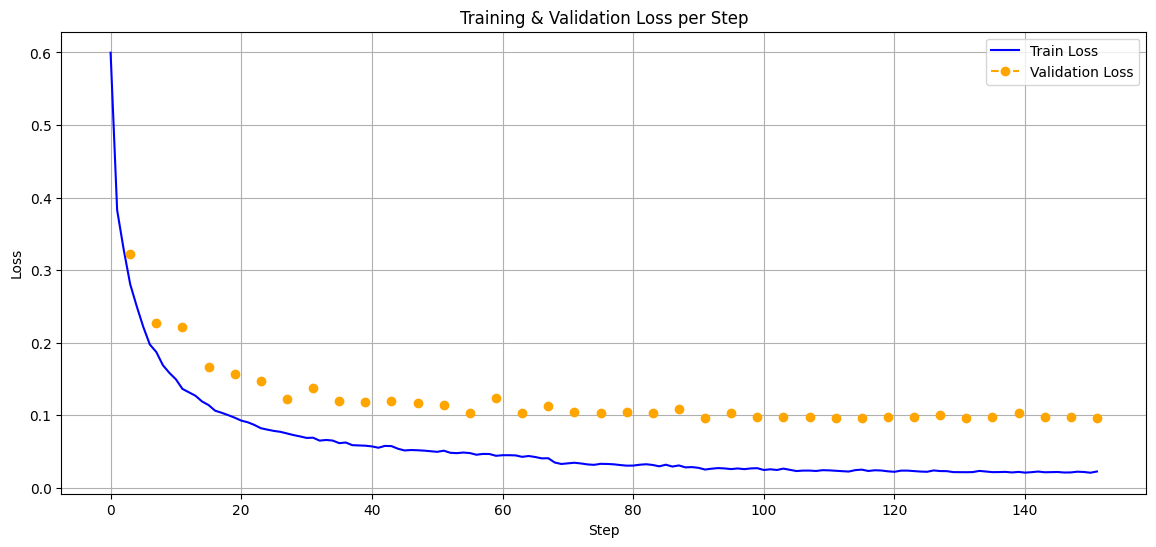

In [33]:
# Prepare validation loss with NaNs
val_losses_for_plot = []
val_idx = 0

for i in range(len(loss_val_dict)):
        # Append (validation_step - 1) NaNs before the validation point
        val_losses_for_plot.extend([np.nan] * (validation_step - 1))
        val_losses_for_plot.append(loss_val_dict[val_idx])
        val_idx += 1

# Make sure both lists have the same length
assert len(loss_train_dict) == len(val_losses_for_plot)

plt.figure(figsize=(14, 6))
plt.plot(loss_train_dict, label='Train Loss', color='blue')
plt.plot(val_losses_for_plot, label='Validation Loss', color='orange', marker='o', linestyle='--')

plt.title('Training & Validation Loss per Step')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [34]:
print(len(loss_train_dict))

152


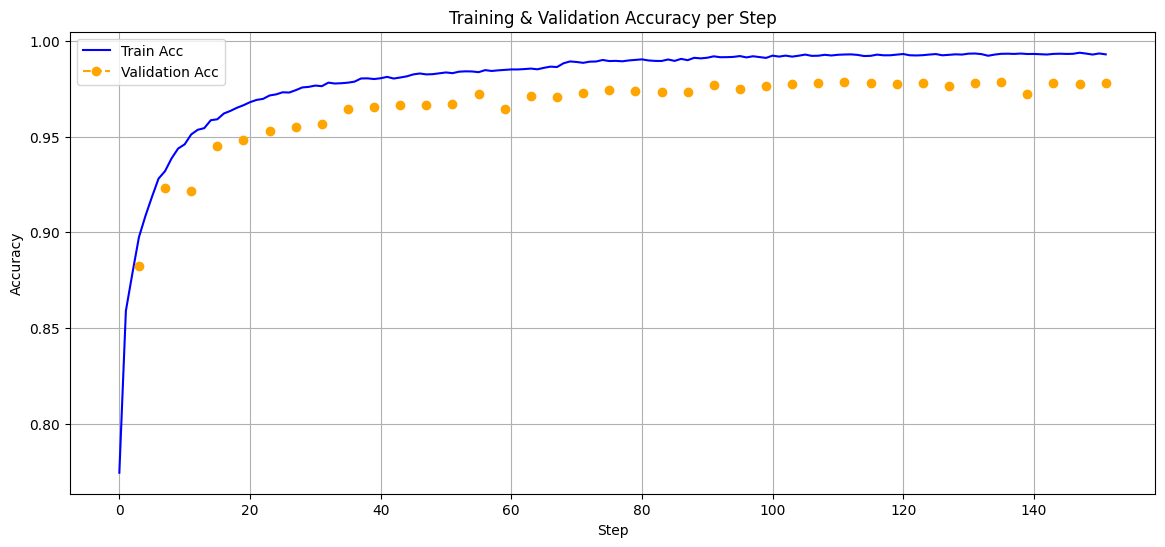

In [35]:
# Prepare validation loss with NaNs
val_acc_for_plot = []
val_idx = 0

for i in range(len(acc_val_dict)):
        # Append (validation_step - 1) NaNs before the validation point
        val_acc_for_plot.extend([np.nan] * (validation_step - 1))
        val_acc_for_plot.append(acc_val_dict[val_idx])
        val_idx += 1

# Make sure both lists have the same length
assert len(acc_train_dict) == len(val_acc_for_plot)

plt.figure(figsize=(14, 6))
plt.plot(acc_train_dict, label='Train Acc', color='blue')
plt.plot(val_acc_for_plot, label='Validation Acc', color='orange', marker='o', linestyle='--')

plt.title('Training & Validation Accuracy per Step')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## Test set inferrence and metrics score

In [36]:
test_loss = 0
test_acc = 0
test_precision = 0
test_recall = 0
test_f1 = 0

with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        outputs = model(X_test)
        loss = criterion(outputs, y_test)
        test_loss += loss.item()
        test_acc += calculate_accuracy(outputs, y_test).item()
        test_precision += calculate_precision(outputs, y_test).item()
        test_recall += calculate_recall(outputs, y_test).item()
        test_f1 += calculate_f1(outputs, y_test).item()

test_loss /= len(test_loader)
test_acc /= len(test_loader)
test_precision /= len(test_loader)
test_recall /= len(test_loader)
test_f1 /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 score: {test_f1:.4f}")

Test Loss: 0.1197
Accuracy: 0.9761
Precision: 0.6041
Recall: 0.6652
F1 score: 0.6100


In [37]:
# import torch
# from transformers import PatchTSMixerConfig, PatchTSMixerForTimeSeriesClassification

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # Define model configuration
# config = PatchTSMixerConfig(
#     num_input_channels=1,  
#     num_targets=len(label_train.unique()), 
#     context_length=187,
#     patch_length=12,
#     stride=12,
#     use_cls_token=True,
# )

# # Initialize model
# model2 = PatchTSMixerForTimeSeriesClassification(config=config).to(device)

# # Convert ECG data to tensor and reshape
# ecg_train_tensor = torch.tensor(ecg_train.values, dtype=torch.float32).unsqueeze(-1).to(device)  
# label_train_tensor = torch.tensor(label_train.values, dtype=torch.long)  

# ecg_test_tensor = torch.tensor(ecg_test.values, dtype=torch.float32).unsqueeze(-1)  
# label_test_tensor = torch.tensor(label_test.values, dtype=torch.long)  

# # Forward pass
# outputs = model2(past_values=ecg_train_tensor)
# logits = outputs.prediction_logits  

# # Print shape of output
# print(logits.shape)  


In [38]:
print(labels)

{0: 'Normal', 1: 'Artial Premature', 2: 'Premature ventricular contraction', 3: 'Fusion of ventricular and normal', 4: 'Fusion of paced and normal'}
